In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


In [2]:
df_omie_b = pd.read_csv('../../data/df_omie_blind.csv')
df_omie_l = pd.read_csv('../../data/df_omie_labelled.csv')
filtered_cat = pd.read_csv('../../data/filtered_categories.csv')
unit_list = pd.read_csv('../../data/unit_list.csv')

In [3]:
data = df_omie_l.merge(filtered_cat, on='Codigo', how='left')
data = data.merge(unit_list, on='Codigo', how='left')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2409526 entries, 0 to 2409525
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Codigo                object 
 1   Descripcion           object 
 2   fechaHora             object 
 3   PrecEuro              float64
 4   Energia               float64
 5   Categoria             object 
 6   Descripción           object 
 7   Agente                object 
 8   Porcentaje_Propiedad  float64
 9   Tipo_Unidad           object 
 10  Zona/Frontera         object 
 11  Tecnología            object 
dtypes: float64(3), object(9)
memory usage: 220.6+ MB


In [5]:
data.sort_values(by=['Codigo', 'fechaHora'], inplace=True)

In [6]:
data['fechaHora'].min(), data['fechaHora'].max()

('2024-02-29 00:00:00', '2024-06-01 22:00:00')

In [7]:
def time_features(df):
    df['fechaHora'] = pd.to_datetime(df['fechaHora'])
    df['year'] = df['fechaHora'].dt.year
    df['month'] = df['fechaHora'].dt.month
    df['day'] = df['fechaHora'].dt.day
    df['hour'] = df['fechaHora'].dt.hour
    df['minute'] = df['fechaHora'].dt.minute
    df['weekday'] = df['fechaHora'].dt.weekday
    return df

In [8]:
def sin_time(df):
    df['sin_hour'] = np.sin(2*np.pi*df['hour']/24)
    df['sin_month'] = np.sin(2*np.pi*df['month']/12)
    df['sin_day'] = np.sin(2*np.pi*df['day']/31)
    df['sin_weekday'] = np.sin(2*np.pi*df['weekday']/7)
    return df

In [9]:
data = time_features(data)
data = sin_time(data)


In [10]:
plants = data['Codigo'].unique()
print(len(plants))

1069


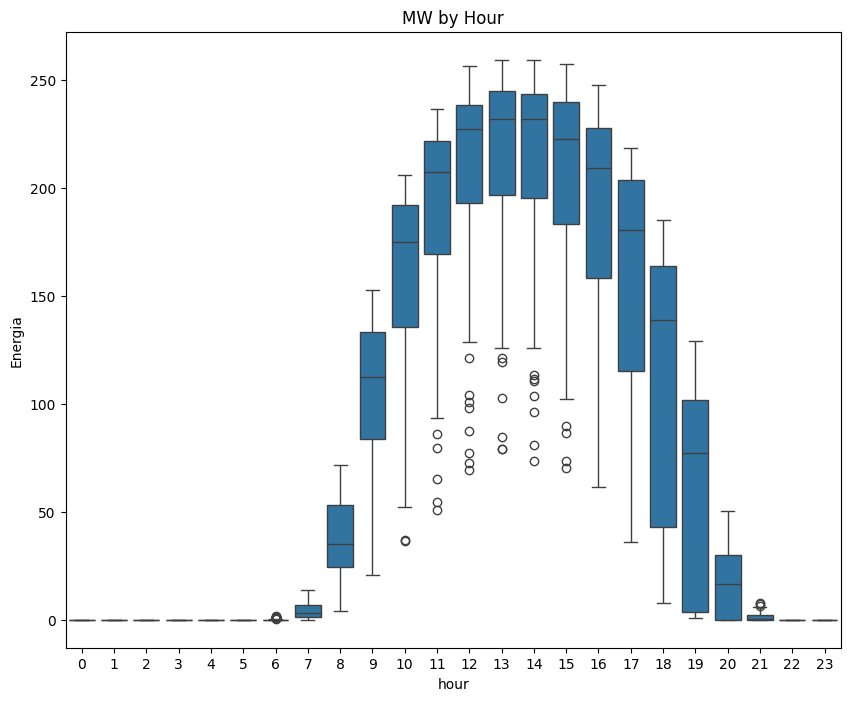

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=data[data['Codigo']==plants[1]], x='hour', y='Energia')
ax.set_title('MW by Hour')
plt.show()

/var/folders/p1/vj5nk3dj08nbdgjg1lst8k_w0000gn/T/ipykernel_99335/3657834191.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data[data['Codigo']==plants[0]], x='month', y='Energia', palette='Blues')


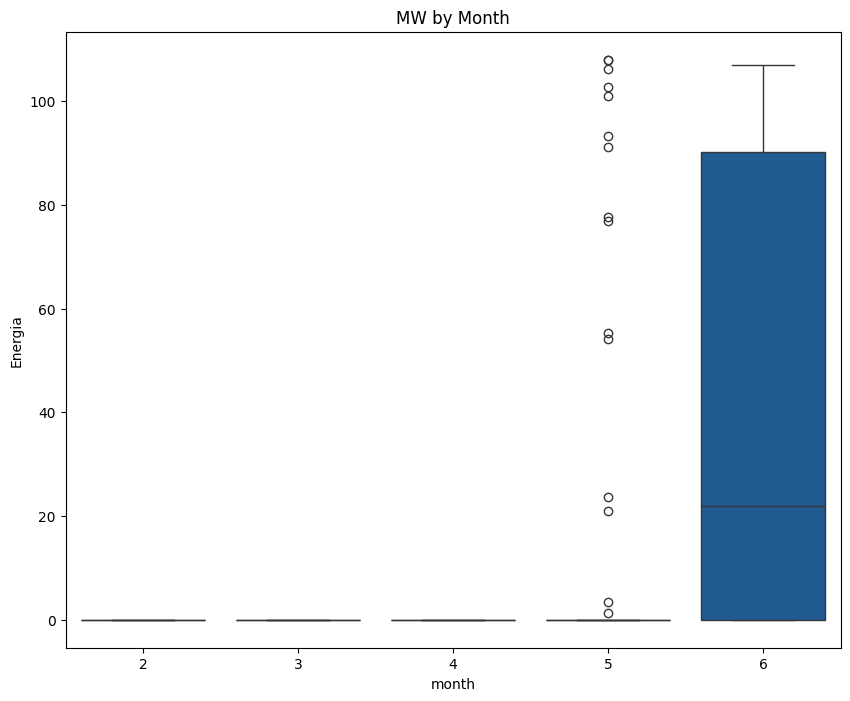

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=data[data['Codigo']==plants[0]], x='month', y='Energia', palette='Blues')
ax.set_title('MW by Month')
plt.show()

In [13]:
train = data.loc[data['fechaHora'] < '2024-05-01']
test = data.loc[data['fechaHora'] >= '2024-05-01']

In [14]:
encoder = OrdinalEncoder()
cat_cols=data.select_dtypes(include=['object']).columns
data[cat_cols] = encoder.fit_transform(data[cat_cols])

In [15]:
def xgb_mae_sklearn(y_true, y_pred):
    mae_value = np.mean(np.abs(y_true - y_pred))
    return 'mae', mae_value

In [16]:
def impute_zero_windows(df, forecast_col='predicted', original_energy_col='Energia', group_col='Codigo', window_size=3, threshold=0.1):
    """
    Impute forecast values to 0 in periods where the rolling average of the original energy is below a threshold,
    computed separately for each group defined by `group_col`.
    """
    # Compute the rolling average for each group using transform.
    rolling_avg = df.groupby(group_col)[original_energy_col].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )
    
    # Create a boolean mask where the rolling average is below the threshold.
    zero_mask = rolling_avg < threshold
    
    # Set the forecast values to 0 where the condition holds.
    df.loc[zero_mask, forecast_col] = 0
    
    return df


In [17]:
TARGET = 'Energia_stationary'

FEATURES = data.columns.difference([TARGET])
FEATURES = FEATURES.drop('fechaHora')
FEATURES

Index(['Agente', 'Categoria', 'Codigo', 'Descripcion', 'Descripción',
       'Energia', 'Porcentaje_Propiedad', 'PrecEuro', 'Tecnología',
       'Tipo_Unidad', 'Zona/Frontera', 'day', 'hour', 'minute', 'month',
       'sin_day', 'sin_hour', 'sin_month', 'sin_weekday', 'weekday', 'year'],
      dtype='object')

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# --------------------------
# STEP 1: Data Preparation
# --------------------------

# Assume 'data' is your DataFrame and its index is a datetime index.
# Also assume that 'Energia' is your target column.
data = data.sort_index()

# --- Stationarity Transformation ---
# We create a log-transformed version of 'Energia'.
# (If your data has zeros or negative values, consider a different transformation or a shift.)
data['Energia_log'] = np.log(data['Energia']+1)

# Next, we difference the log-transformed series to remove any trend.
# This is a common technique to help achieve stationarity.
data['Energia_stationary'] = data['Energia_log'].diff()

# --- Lag Features ---
# Here we add lag features so that to predict time t+1 we have data from time t.
# For hourly data, we add 24 lag features (covering the past 24 hours = 1 day).
n_lags = 24
for lag in range(1, n_lags + 1):
    data[f'lag_{lag}'] = data['Energia_stationary'].shift(lag)

# Drop rows with NaN values introduced by differencing and lagging.
data = data.dropna()

# --------------------------
# STEP 2: Time Series Split & Model Training
# --------------------------

# Define a TimeSeriesSplit object.
# Here, test_size=24*30 means that each test set is 30 days (if data is hourly)
# and gap=24 leaves a 24-hour gap between train and test to avoid leakage.
tss = TimeSeriesSplit(n_splits=5, test_size=24*30, gap=24)

# Define the features and target.
# In this example, we use only the lag features as predictors.
TARGET = 'Energia_stationary'
FEATURES = data.columns.difference([TARGET])
FEATURES = FEATURES.drop('fechaHora')

scores = []
all_results = []  # To store a DataFrame per fold containing actual, predicted, and error values.

fold = 0
for train_idx, val_idx in tss.split(data):
    # Split the data into training and test sets.
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    # Define the XGBoost regressor.
    reg = xgb.XGBRegressor(
        n_estimators=1000,
        early_stopping_rounds=50,
        objective='reg:squarederror',  # updated objective; 'reg:linear' is deprecated.
        max_depth=3,
        learning_rate=0.01,
        verbosity=0  # Set to 0 to reduce logging; adjust if needed.
    )
    
    # Train the model with evaluation on both training and test sets.
    reg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )
    
    # Predict on the test set.
    y_pred = reg.predict(X_test)
    
    y_pred = y_pred + 1e-8
    y_test = y_test + 1e-8
    
    # Store results (actual, predicted, error) in a DataFrame using the original datetime index.
    fold_results = pd.DataFrame({
        'actual': y_test,
        'predicted': y_pred
    }, index=test.index)
    
    fold_results['error'] = fold_results['actual'] - fold_results['predicted']
    fold_results['fold'] = fold  # Optionally keep track of the fold.
    
    all_results.append(fold_results)
    
    # Evaluate predictions using MAE and MAPE.
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    scores.append((mae, mape))
    
    print(f"Fold {fold} -- MAE: {mae:.4f}, MAPE: {mape:.4f}")
    fold += 1

print("All fold scores (MAE, MAPE):", scores)


[0]	validation_0-rmse:1.39123	validation_1-rmse:1.40779
[100]	validation_0-rmse:1.01716	validation_1-rmse:1.05212
[200]	validation_0-rmse:0.88577	validation_1-rmse:0.93489
[300]	validation_0-rmse:0.81215	validation_1-rmse:0.87710
[400]	validation_0-rmse:0.76404	validation_1-rmse:0.83580
[500]	validation_0-rmse:0.72538	validation_1-rmse:0.80074
[600]	validation_0-rmse:0.69650	validation_1-rmse:0.77254
[700]	validation_0-rmse:0.67277	validation_1-rmse:0.74968
[800]	validation_0-rmse:0.65331	validation_1-rmse:0.73186
[900]	validation_0-rmse:0.63641	validation_1-rmse:0.71768
[999]	validation_0-rmse:0.62157	validation_1-rmse:0.70552
Fold 0 -- MAE: 0.5328, MAPE: 2296433.3573
[0]	validation_0-rmse:1.39123	validation_1-rmse:1.39528
[100]	validation_0-rmse:1.01701	validation_1-rmse:1.03295
[200]	validation_0-rmse:0.88615	validation_1-rmse:0.92068
[300]	validation_0-rmse:0.81194	validation_1-rmse:0.86278
[400]	validation_0-rmse:0.76392	validation_1-rmse:0.82107
[500]	validation_0-rmse:0.72530	va

In [19]:
results = pd.concat(all_results).sort_index()

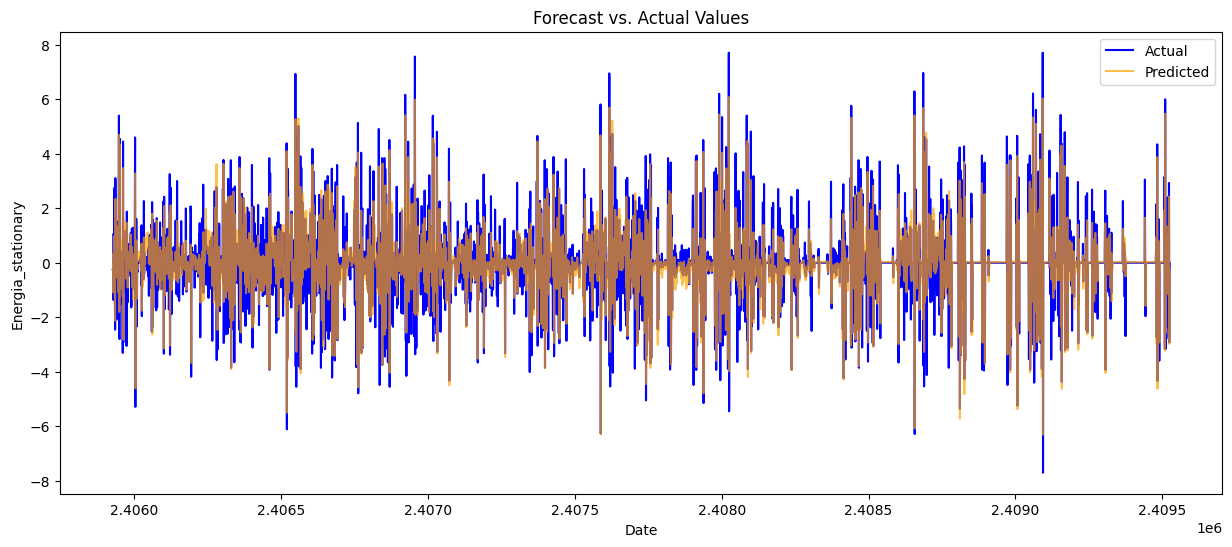

In [20]:
# Plot Actual vs. Predicted values.
plt.figure(figsize=(15, 6))
plt.plot(results.index, results['actual'], label='Actual', color='blue')
plt.plot(results.index, results['predicted'], label='Predicted', color='orange', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Energia_stationary')
plt.title('Forecast vs. Actual Values')
plt.legend()
plt.show()

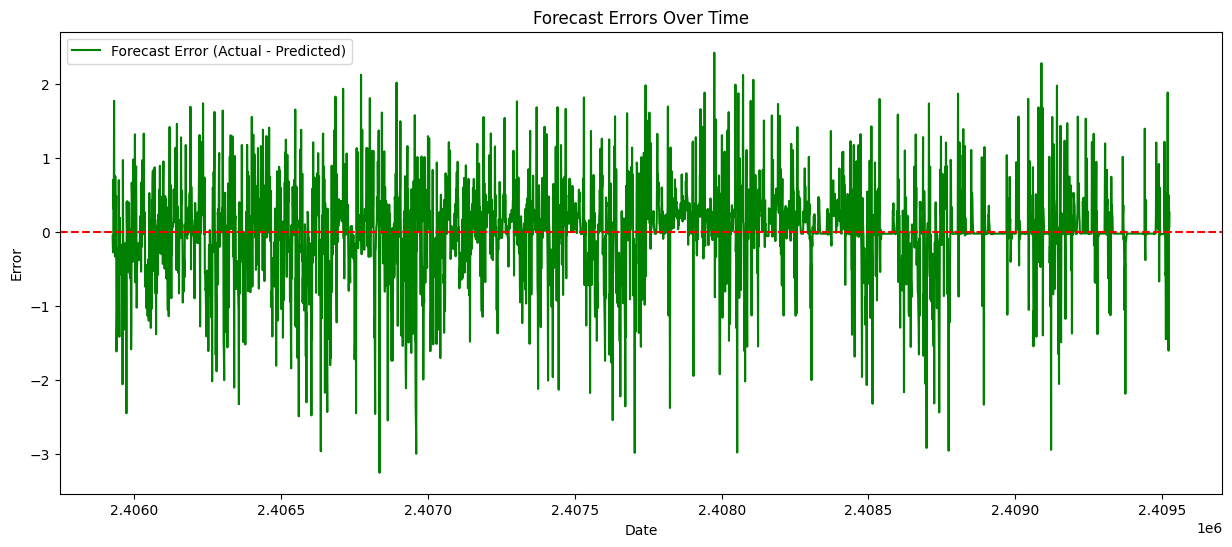

In [21]:
# Plot Forecast Errors Over Time.
plt.figure(figsize=(15, 6))
plt.plot(results.index, results['error'], label='Forecast Error (Actual - Predicted)', color='green')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Error')
plt.title('Forecast Errors Over Time')
plt.legend()
plt.show()

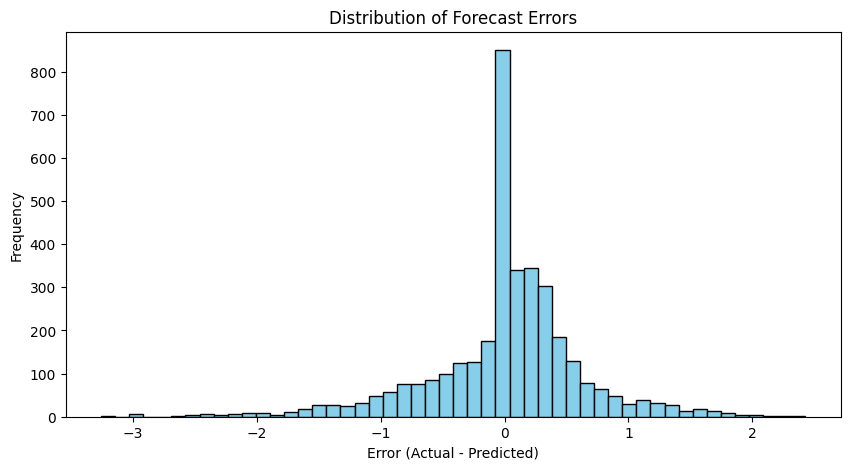

In [22]:
# Plot the Distribution of Forecast Errors.
plt.figure(figsize=(10, 5))
plt.hist(results['error'], bins=50, edgecolor='k', color='skyblue')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Forecast Errors')
plt.show()

In [23]:
mae = np.mean([score[0] for score in scores])
mape = np.mean([score[1] for score in scores])
print(f'Score across folds: MAE {mae}, MAPE {mape}')
# print(f'Fold scores:{scores}')

Score across folds: MAE 0.4200321588604908, MAPE 3281886.884581901


In [24]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# Get the feature names from the training data
feature_names = X_train.columns.tolist()

# Get the most important features and their importances
importances = reg.feature_importances_

# Print the most important features in descending order of importance
print("Most important features:")
for i, importance in enumerate(importances):
    print(f"{i+1}. {feature_names[i]}: {importance}")

Most important features:
1. Agente: 0.01522844098508358
2. Categoria: 0.012552903033792973
3. Codigo: 0.03284616023302078
4. Descripcion: 0.025521153584122658
5. Descripción: 0.0
6. Energia: 0.27577486634254456
7. Energia_log: 0.0
8. Porcentaje_Propiedad: 0.0
9. PrecEuro: 0.02572280913591385
10. Tecnología: 0.008261442184448242
11. Tipo_Unidad: 0.0
12. Zona/Frontera: 0.0
13. day: 0.0
14. hour: 0.047937773168087006
15. lag_1: 0.2087937444448471
16. lag_10: 0.008177880197763443
17. lag_11: 0.00534349400550127
18. lag_12: 0.011746665462851524
19. lag_13: 0.0
20. lag_14: 0.013692271895706654
21. lag_15: 0.002578538842499256
22. lag_16: 0.015848323702812195
23. lag_17: 0.0
24. lag_18: 0.020264703780412674
25. lag_19: 0.0
26. lag_2: 0.08059386909008026
27. lag_20: 0.0
28. lag_21: 0.0
29. lag_22: 0.004725804552435875
30. lag_23: 0.016573404893279076
31. lag_24: 0.005601815413683653
32. lag_3: 0.0457259863615036
33. lag_4: 0.02850937470793724
34. lag_5: 0.020350517705082893
35. lag_6: 0.017040

In [ ]:
!pip install pmdarima tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 MB 30.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For auto_arima
from pmdarima import auto_arima

# For LSTM (Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# --------------------------
# STEP 1: Data Preparation
# --------------------------

# Assume 'data' is your DataFrame with a datetime index and a column 'Energia'
data = data.sort_index()

# --- Stationarity Transformation ---
# Because 'Energia' can be 0, add a small constant (here, 1) so that log(0+1)=0.
data['Energia_log'] = np.log(data['Energia'] + 1)
# First-difference the log-transformed series to remove trend and help achieve stationarity.
data['Energia_stationary'] = data['Energia_log'].diff()

# --- Lag Features ---
# Create lag features so that to predict time t+1 you have data at time t.
# For hourly data, we create 24 lag features (i.e. one day's worth).
n_lags = 24
for lag in range(1, n_lags + 1):
    data[f'lag_{lag}'] = data['Energia_stationary'].shift(lag)

# Drop rows with NaN values introduced by differencing and lagging.
data = data.dropna()

# Define the features and target for the regressors.
FEATURES = [f'lag_{lag}' for lag in range(1, n_lags + 1)]
TARGET = 'Energia_stationary'

# --------------------------
# STEP 2: Benchmarking Setup
# --------------------------

# Set up a TimeSeriesSplit.
# Here, test_size=24*30 creates test folds of 30 days (for hourly data),
# and gap=24 ensures a 24-hour gap between training and testing (reducing leakage).
tss = TimeSeriesSplit(n_splits=5, test_size=24*30, gap=24)

# Initialize a dictionary to store metrics for each model.
models = ['auto_arima', 'xgb', 'lgbm', 'lstm']
results = {model: {'mae': [], 'mape': [], 'aic': [], 'bic': []} for model in models}

fold_num = 0
for train_idx, test_idx in tss.split(data):
    print(f"\n===== Fold {fold_num} =====")
    # Split the data.
    train = data.iloc[train_idx]
    test = data.iloc[test_idx]
    
    # Extract features and target.
    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    # --------------------------
    # Model 1: auto_arima
    # --------------------------
    # auto_arima works with 1D arrays.
    # auto_model = auto_arima(
    #     y_train, 
    #     seasonal=False, 
    #     stepwise=True, 
    #     suppress_warnings=True, 
    #     error_action='ignore'
    # )
    # # Forecast the entire test set.
    # n_periods = len(y_test)
    # y_pred_auto = auto_model.predict(n_periods=n_periods)
    
    # mae_auto = mean_absolute_error(y_test, y_pred_auto)
    # mape_auto = mean_absolute_percentage_error(y_test, y_pred_auto)
    # aic_auto = auto_model.aic()
    # bic_auto = auto_model.bic()
    
    # results['auto_arima']['mae'].append(mae_auto)
    # results['auto_arima']['mape'].append(mape_auto)
    # results['auto_arima']['aic'].append(aic_auto)
    # results['auto_arima']['bic'].append(bic_auto)
    
    # print(f"auto_arima  --> MAE: {mae_auto:.4f}, MAPE: {mape_auto:.4f}, AIC: {aic_auto:.2f}, BIC: {bic_auto:.2f}")
    
    # --------------------------
    # Model 2: XGBoost
    # --------------------------
    xgb_reg = xgb.XGBRegressor(
        base_score=0.5,
        booster='gbtree',
        n_estimators=1000,
        early_stopping_rounds=50,
        # Note: 'reg:linear' is deprecated; consider using 'reg:squarederror'
        objective='reg:linear',  
        max_depth=3,
        learning_rate=0.01,
        verbosity=0
    )
    xgb_reg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
    )
    y_pred_xgb = xgb_reg.predict(X_test)
    mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
    mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
    # AIC and BIC are not defined for XGBoost – record as NaN.
    results['xgb']['mae'].append(mae_xgb)
    results['xgb']['mape'].append(mape_xgb)
    results['xgb']['aic'].append(np.nan)
    results['xgb']['bic'].append(np.nan)
    
    print(f"XGBoost    --> MAE: {mae_xgb:.4f}, MAPE: {mape_xgb:.4f}")
    
    # --------------------------
    # Model 3: LightGBM
    # --------------------------
    lgbm_reg = LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=3
    )
    lgbm_reg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
    )
    y_pred_lgbm = lgbm_reg.predict(X_test)
    mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
    mape_lgbm = mean_absolute_percentage_error(y_test, y_pred_lgbm)
    results['lgbm']['mae'].append(mae_lgbm)
    results['lgbm']['mape'].append(mape_lgbm)
    results['lgbm']['aic'].append(np.nan)
    results['lgbm']['bic'].append(np.nan)
    
    print(f"LightGBM   --> MAE: {mae_lgbm:.4f}, MAPE: {mape_lgbm:.4f}")
    
    # --------------------------
    # Model 4: LSTM
    # --------------------------
    # Reshape inputs to 3D: (samples, timesteps, features). Here, each sample has 24 timesteps and 1 feature.
    # X_train_lstm = X_train.values.reshape(-1, n_lags, 1)
    # X_test_lstm = X_test.values.reshape(-1, n_lags, 1)
    
    # # Build a simple LSTM model.
    # lstm_model = Sequential()
    # lstm_model.add(LSTM(50, activation='relu', input_shape=(n_lags, 1)))
    # lstm_model.add(Dense(1))
    # lstm_model.compile(optimizer='adam', loss='mse')
    
    # # Early stopping callback.
    # early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    
    # # Fit the LSTM model.
    # lstm_model.fit(
    #     X_train_lstm, y_train.values,
    #     epochs=50,
    #     batch_size=32,
    #     verbose=0,
    #     callbacks=[early_stop]
    # )
    
    # # Make predictions.
    # y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()
    # mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
    # mape_lstm = mean_absolute_percentage_error(y_test, y_pred_lstm)
    # results['lstm']['mae'].append(mae_lstm)
    # results['lstm']['mape'].append(mape_lstm)
    # results['lstm']['aic'].append(np.nan)
    # results['lstm']['bic'].append(np.nan)
    
    # print(f"LSTM       --> MAE: {mae_lstm:.4f}, MAPE: {mape_lstm:.4f}")
    
    fold_num += 1

# --------------------------
# STEP 3: Aggregate Results
# --------------------------

# Create a DataFrame summarizing the (averaged) results.
benchmark_results = []
for model in models:
    avg_mae = np.mean(results[model]['mae'])
    avg_mape = np.mean(results[model]['mape'])
    # For models without AIC/BIC (XGBoost, LightGBM, LSTM), the average remains NaN.
    avg_aic = np.mean(results[model]['aic']) if not all(np.isnan(x) for x in results[model]['aic']) else np.nan
    avg_bic = np.mean(results[model]['bic']) if not all(np.isnan(x) for x in results[model]['bic']) else np.nan
    
    benchmark_results.append({
        'Model': model,
        'MAE': avg_mae,
        'MAPE': avg_mape,
        'AIC': avg_aic,
        'BIC': avg_bic
    })

results_df = pd.DataFrame(benchmark_results)
print("\n===== Benchmark Results =====")
print(results_df)



===== Fold 0 =====
XGBoost    --> MAE: 0.9025, MAPE: 115557941757729.0156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 767862, number of used features: 24
[LightGBM] [Info] Start training from score 0.000002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [ ]:
results_df

,Model,MAE,MAPE,AIC,BIC
0,auto_arima,NaN,NaN,NaN,NaN
1,xgb,0.890142,1.267057e+14,NaN,NaN
2,lgbm,0.891247,1.253254e+14,NaN,NaN
3,lstm,NaN,NaN,NaN,NaN
